<a href="https://colab.research.google.com/github/sanjanagarai/InterIIT_Team1_Task2/blob/main/ViLT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing modules

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.3 MB/s eta 0:00:00


In [2]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image
import pandas as pd
import os
import torch
import torch.nn as nn


connecting to drive


In [3]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


Mounted at /content/drive


## VQA MODEL initialization

In [5]:
# Load your dataset
data = pd.read_csv('/content/question_data.csv')

# Define your image folder
image_folder = '/content/drive/MyDrive/VQA_RAD_Dataset/Images'

# Initialize the ViLT processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# Create a mapping of answers to label IDs
answer_to_label = {answer: label for label, answer in enumerate(data['answer'].unique())}



## Training loop

In [6]:
# Define a loss function (e.g., CrossEntropyLoss) for classification tasks
criterion = nn.CrossEntropyLoss()

# Fine-tune the model
for index, row in data.iterrows():
    image_name = row['image_name'] + '.jpg'
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)
    question = row['question']
    answer = row['answer']

    # Prepare inputs
    encoding = processor(image, question, return_tensors="pt")

    # Forward pass
    outputs = model(**encoding)
    logits = outputs.logits

    # Convert the answer to a label ID
    answer_label = answer_to_label.get(answer, -1)  # -1 for unknown answers
    if answer_label != -1:
        labels = torch.tensor([answer_label])
        loss = criterion(logits, labels)
        loss.backward()
    else:
        print(f"Unknown answer: {answer} for question: {question}")

# Save the fine-tuned model after training
model.save_pretrained("your_fine_tuned_model_directory")

In [7]:
from transformers import ViltProcessor, ViltForQuestionAnswering

# Load the fine-tuned model
model = ViltForQuestionAnswering.from_pretrained("your_fine_tuned_model_directory")

# Initialize the ViLT processor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")


Testing model on a single image and question

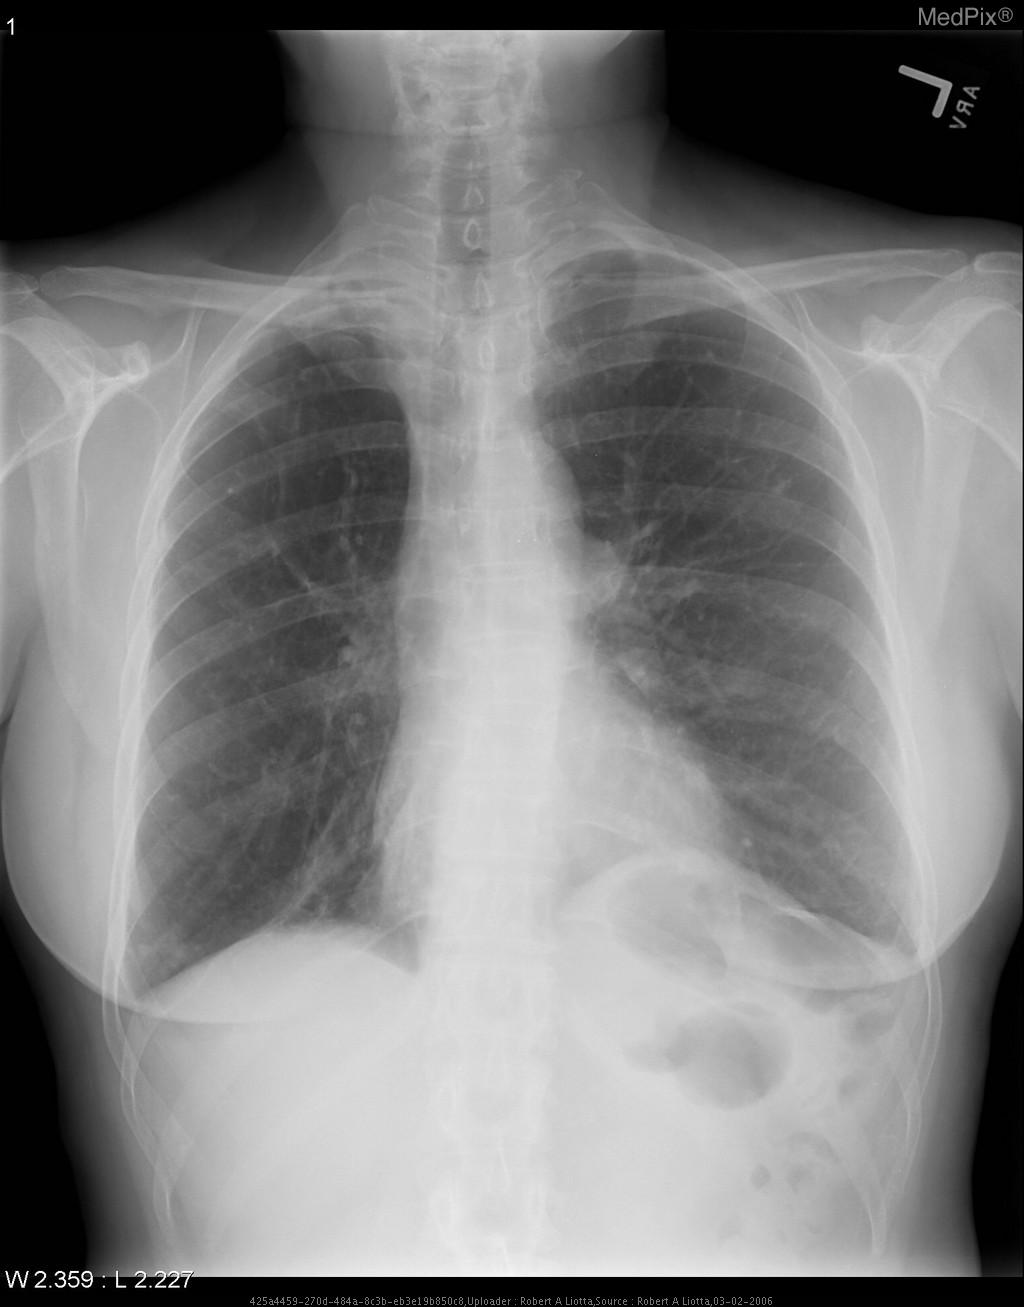

Is the trachea midline?
Predicted answer: yes


In [10]:
from IPython.display import Image, display
from PIL import Image as PILImage

# Path to the image file
image_path = "/content/drive/MyDrive/VQA_RAD_Dataset/Images/synpic28602.jpg"

# Display the image
display(Image(filename=image_path))

# Define the question
question = "Is the trachea midline?"  # Replace with your question

print(question)

# Load the image using PIL
image = PILImage.open(image_path)

# Prepare inputs
encoding = processor(image, question, return_tensors="pt")

# Forward pass to predict the answer
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
predicted_answer = model.config.id2label[idx]

# Print the predicted answer
print("Predicted answer:", predicted_answer)


## Evaluation of model

In [11]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import pandas as pd

# Define the path to your evaluation dataset
evaluation_data_path = "/content/question_data.csv"

# Load the evaluation dataset
evaluation_data = pd.read_csv(evaluation_data_path)

# Initialize the ViLT processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("your_fine_tuned_model_directory")

# Define a function to evaluate accuracy
def evaluate_model_accuracy(data, processor, model):
    correct_predictions = 0
    total_predictions = len(data)

    for index, row in data.iterrows():
        image_name = row['image_name'] + '.jpg'
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path)
        question = row['question']
        answer = row['answer']

        # Prepare inputs
        encoding = processor(image, question, return_tensors="pt")

        # Forward pass to predict the answer
        outputs = model(**encoding)
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        predicted_answer = model.config.id2label[idx]

        # Check if the predicted answer matches the ground-truth answer
        if predicted_answer == answer:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

# Evaluate the model on the dataset
accuracy = evaluate_model_accuracy(evaluation_data, processor, model)

# Print the accuracy
print("Model Accuracy:", accuracy)


Model Accuracy: 0.09119217081850534
